# Interactive tool for analyzing trained models on the ePodium dataset

1. [Input Data](#1)
2. [Deep Learning Model](#02)
3. [Make predictions on test-set](#3)

#### Import Packages
Note: This notebook may output tensorflow errors if cuda is not properly installed. The notebook still functions with these errors.

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets
import tensorflow as tf

from functions import epodium, epodium_deep_learning, display_helper
from models.dnn import fully_connected_model
from models.hfawaz import cnn, encoder

import local_paths

2022-09-22 20:31:16.360683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 20:31:16.360723: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: initialization failed

<br>

<a id="1"></a>
## 1. Input Data 

####  Choose which processed data to use
Choose from the different processed _experiment_event.npy_ files. If the _local_path.split_ folder is empty, process the raw ePodium files in the _epodium_processing_ notebook.

<span style="color:blue"> My tensorflow isn't allowing me to run this, but we need to talk about why the double parens below, typo?? </span>

In [2]:
processing_methods = sorted((f for f in os.listdir(local_paths.split) if not f.startswith(".")))
processing_method_widget = ipywidgets.RadioButtons(options=processing_methods, 
                                                   description='processing:',
                                                   value = 'autoreject_128hz')
display(processing_method_widget)

NameError: name 'local_paths' is not defined

In [3]:
cleaning_method = processing_method_widget.value.split('_')[0]
experiment_list = epodium_deep_learning.clean_experiments(cleaning_method)

Analyzed: 228, bad: 42
186 experiments have enough epochs for analysis.


#### Visualise the data sequence of a single participant


In [4]:
def plot_standard_deviant_instance(experiment, codition, avg, noise):    
    # Create data instance
    participant_sequence = epodium_deep_learning.EvokedDataIterator([experiment], 
                                                                    processing_method_widget.value,
                                                                    n_experiments_batch = 1,
                                                                    n_trials_averaged = avg,
                                                                    gaussian_noise = noise*1e-6)
    x, y = participant_sequence.__getitem__(0)
    print(f"The data instance has shape: {x.shape}")

    # Plot an evoked (ERP) of the specified condition
    index = epodium.conditions.index(codition)
    epodium.plot_array_as_evoked(x[index][:32], frequency = 128, n_trials = avg, ylim = [-20, 20])
    epodium.plot_array_as_evoked(x[index][32:], frequency = 128, n_trials = avg, ylim = [-20, 20])

# Create widgets
experiment_widget = ipywidgets.Dropdown(options=sorted(experiment_list), description='Experiment:')
condition_widget = ipywidgets.RadioButtons(options=epodium.conditions, description='Condition:')
n_trials_averaged_widget = ipywidgets.IntSlider(value=60, min=1, max=80,description='Averaged trials:')
gaussian_noise_widget = ipywidgets.FloatSlider(value=1, min=0, max=5,description='Noise (micro-volt):')

# Widget settings
options = {'experiment':experiment_widget, 'codition':condition_widget, 'avg':n_trials_averaged_widget, 'noise':gaussian_noise_widget}
ui = ipywidgets.VBox([experiment_widget, condition_widget, n_trials_averaged_widget, gaussian_noise_widget])
out = ipywidgets.interactive_output(plot_standard_deviant_instance, options)
display(ui, out)

Output()

<br>

<a id="02"></a>
## 2. Deep Learning Model

#### Choose a trained model
Choose from the trained models in the _local_paths.models_ folder. If the folder is empty, train a model in the _epodium_model_training_ notebook.

In [5]:
# Required plot setting
%matplotlib inline 
trained_models = sorted((f for f in os.listdir(local_paths.models) if not f.startswith(".")))

model_widget = ipywidgets.RadioButtons(options=trained_models, description='Models:')
display(model_widget)

history = []
                                       
def load_model(mod):
    base_path = os.path.join(local_paths.models, mod)

    path_history = os.path.join(base_path, "history.npy")
    path_model = os.path.join(base_path, "model")
    path_testset = os.path.join(base_path, "testset.txt")
    path_weights = os.path.join(base_path, "weights.h5")
    
    global model
    global testset
    global history

    # Load Model
    if(os.path.exists(path_model)):
        print(f"Loading Model: '{model_widget.value}'.")

        # Loads the entire model from a folder:
        model = tf.keras.models.load_model(path_model)
        model.load_weights(path_weights)
        # Reads the test-set of the trained model and puts the experiment names into a list:
        testset = open(path_testset, "r").read().split()
        # Loads the training history dictionary:
        history = np.load(path_history, allow_pickle=True).item()
        
        # Show Loss of Training History
        display_helper.show_plot(x = range(len(history['loss'][:])), y = history['loss'][:] ,xlabel = "epochs", ylabel = "validation loss", title = "Loss during training")
        display_helper.show_plot(x = range(len(history['loss']))[:], y = history['val_loss'][:] ,xlabel = "epochs", ylabel = "validation loss", title = "Validation loss during training")
        print(f"The lowest validation loss is {round(min(history['val_loss']), 3)}")

    else: print("Model not found")

out = ipywidgets.interactive_output(load_model, {'mod': model_widget})
display(out)

RadioButtons(description='Models:', options=('encoder_age_128', 'encoder_age_128_2', 'encoder_age_128_20', 'en…

Output()

<span style="color:blue"> Double parens *2 above, also missing new line after else </span>

<br>

<a id='3'></a>
## 3. Make predictions on test-set


In [14]:
n_passthroughs = 20 # 1 passtrough gives 4 predictions, 1 for each condition
results = []

trainset = list(set(experiment_list) - set(testset))

# For each experiment in the test-set
for experiment in trainset: # TODO: Check difference trainset/testset 
    test_sequence = epodium_deep_learning.EvokedDataIterator([experiment],
                                                             processing_method_widget.value,                                                                    
                                                             n_experiments_batch = n_passthroughs,                                                                    
                                                             n_trials_averaged = 60)

    x, y = test_sequence.__getitem__(0)
    # print(f"The data instance has shape: {x.shape}")

    real_pred = [y[0], np.squeeze(model.predict(x, verbose=0)).mean()]
    results.append(real_pred)
results = np.array(results)

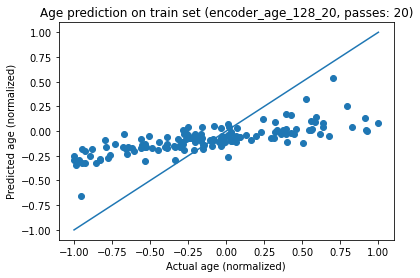

In [15]:
display_helper.show_plot(np.array(results)[:,0], 
                         np.array(results)[:,1], 
                         f"Age prediction on train set (encoder_age_128_20, passes: {n_passthroughs})", 
                         "Actual age (normalized)",
                         "Predicted age (normalized)",
                         scatter = True,
                         show = False)
plt.plot([-1, 1], [-1, 1]) # Line where predicted=actual


In [ ]:
### OLD!


#     label_sex = 'male' if y[index][0] else 'female'
#     label_dyslexia = 'risk' if y[index][1] else 'no risk'
#     label_event = 'deviant' if y[index][2] else 'standard'

#     print (f"{int(y[index][0])}: {label_sex}, \
#          {int(y[index][1])}: {label_risk}, \
#          {int(y[index][2])}: {label_event}")